**LIBRARIES**

2025-04-30 20:37:34.280035: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746045454.476982      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746045454.531280      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1746045468.623020      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


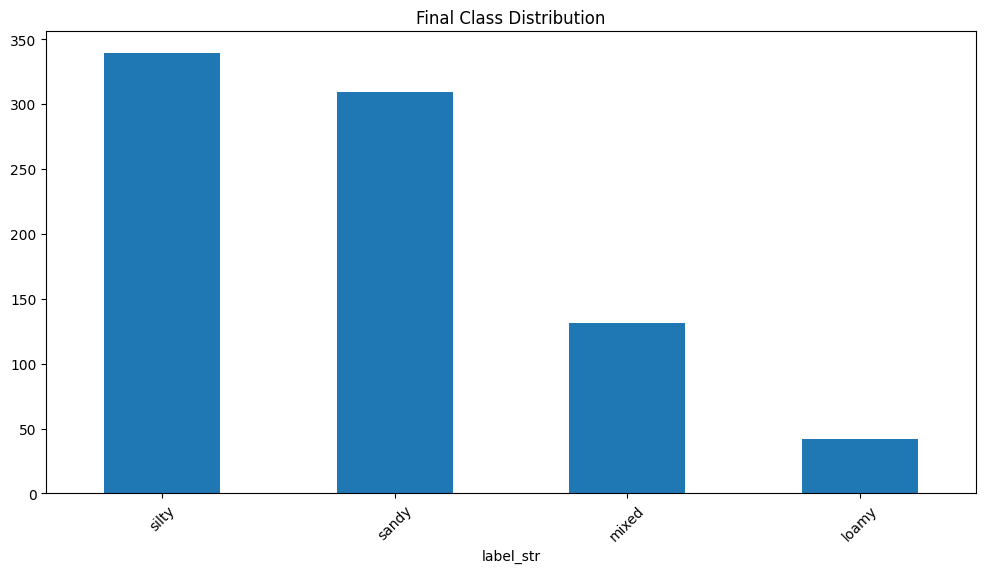

Final classes: {0: 'loamy', 1: 'mixed', 2: 'sandy', 3: 'silty'}

=== Phase 1: Base Model Training ===
27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/8


I0000 00:00:1746046206.487150      58 service.cc:148] XLA service 0x7dde14004df0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746046206.487915      58 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746046209.050455      58 cuda_dnn.cc:529] Loaded cuDNN version 90300


 7/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2699 - loss: 1.4922

I0000 00:00:1746046222.697370      58 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


21/21 ━━━━━━━━━━━━━━━━━━━━ 782s 2s/step - accuracy: 0.3498 - loss: 1.3640 - val_accuracy: 0.4696 - val_loss: 1.1431
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 696s 67ms/step - accuracy: 0.4141 - loss: 1.2260 - val_accuracy: 0.4609 - val_loss: 1.1240
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 693s 25ms/step - accuracy: 0.4682 - loss: 1.1796 - val_accuracy: 0.4174 - val_loss: 1.1264
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 695s 26ms/step - accuracy: 0.4514 - loss: 1.1383 - val_accuracy: 0.4696 - val_loss: 1.1279
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 693s 26ms/step - accuracy: 0.4964 - loss: 1.1326 - val_accuracy: 0.4174 - val_loss: 1.1431

=== Phase 2: Fine-tuning ===
Epoch 1/10


In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, applications
from tensorflow.keras import optimizers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split

# Enable mixed precision for faster computations
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# ─── Optimized Configuration ──────────────────────────────────────────────
class Config:
    DATA_PATH = '/kaggle/input/soil-distribution/model_training_img'
    PHASE1_SIZE = 160  # Better resolution tradeoff
    PHASE2_SIZE = 224
    BATCH_SIZE = 32     # Increased from 16
    MIN_SAMPLES = 40
    EPOCHS_HEAD = 8     # Reduced with early stopping
    EPOCHS_FINE = 10
    FINE_TUNE_PERCENT = 0.3

# ─── Data Loading & Preparation (With Consolidation) ──────────────────────
def load_and_prepare_data(config):
    p = Path(config.DATA_PATH)
    files = list(p.glob('**/*.jpg')) + list(p.glob('**/*.jpeg')) + list(p.glob('**/*.JPG'))
    
    # Fast dataframe creation
    records = []
    for fp in files:
        parts = fp.stem.split('_')
        try:
            texture_idx = parts.index("texture")
            label = '_'.join(parts[texture_idx+1:]).lower()
            records.append({'filepath': str(fp), 'label_str': label})
        except ValueError:
            continue

    df = pd.DataFrame(records)
    
    # Consolidated class mapping with case insensitivity
    consolidation_map = {
        'loamy_sand': 'sandy', 'sandy': 'sandy', 'silty_sand': 'sandy',
        'sandy_silt': 'sandy', 'combined_loamy_sand_sandy_loam': 'sandy',
        'loamy_silt': 'silty', 'clay_silt': 'silty', 
        'combined_loamy_silt_silty_loam': 'silty',
        'clay_loam': 'clay', 'clay_soil': 'clay',
        'combined_clay_loam_loamy_clay': 'clay',
        'complex_mixes': 'mixed', 'loamy_silty_sand': 'mixed',
        'silty_loamy_sand': 'mixed', 'clay_sand': 'mixed',
        'clay_silty_sand': 'mixed', 'loamy_clay_sand': 'mixed',
        'loamy_soil': 'loamy'
    }
    
    # Apply consolidation
    df['label_str'] = df['label_str'].map(consolidation_map).fillna('other')
    df = df[df['label_str'].isin(consolidation_map.values())]
    
    # Filter by minimum samples
    counts = df['label_str'].value_counts()
    df = df[df['label_str'].isin(counts[counts >= config.MIN_SAMPLES].index)]
    
    # Encode labels
    df['label'] = pd.Categorical(df['label_str']).codes
    label_map = dict(enumerate(pd.Categorical(df['label_str']).categories))
    
    # Plot distribution
    plt.figure(figsize=(12,6))
    df['label_str'].value_counts().plot(kind='bar')
    plt.title('Final Class Distribution')
    plt.xticks(rotation=45)
    plt.show()
    
    return df.reset_index(drop=True), label_map

# ─── Optimized Data Pipeline ──────────────────────────────────────────────
class FastDataPipeline:
    def __init__(self, config):
        self.config = config
        self.augment = tf.keras.Sequential([
            layers.RandomFlip('horizontal'),
            layers.RandomRotation(0.15),
            layers.RandomZoom(0.2),
            layers.RandomContrast(0.15)
        ])
        
    def _process_image(self, path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        return img, label

    def create_dataset(self, df, img_size, augment=False):
        ds = tf.data.Dataset.from_tensor_slices(
            (df['filepath'].values, df['label'].values)
        )
        ds = ds.map(self._process_image, num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.cache()
        
        if augment:
            ds = ds.map(
                lambda x,y: (self.augment(x), y),
                num_parallel_calls=tf.data.AUTOTUNE
            )
            
        # Corrected preprocessing
        ds = ds.map(
            lambda x, y: (
                applications.efficientnet.preprocess_input(tf.image.resize(x, [img_size, img_size])),
                y
            ),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        
        return (ds.shuffle(1000)
                .batch(self.config.BATCH_SIZE)
                .prefetch(tf.data.AUTOTUNE))

def build_optimized_model(input_size, num_classes):
    base_model = applications.EfficientNetB1(
        include_top=False,
        weights='imagenet',
        input_shape=(input_size, input_size, 3),
        pooling='avg'
    )
    base_model.trainable = False
    
    inputs = layers.Input(shape=(input_size, input_size, 3))
    x = base_model(inputs)
    x = layers.Dense(256, activation='swish')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
    
    return models.Model(inputs, outputs)

# ─── Training Workflow ────────────────────────────────────────────────────
def main():
    config = Config()
    dp = FastDataPipeline(config)
    
    # Load and prepare data
    df, label_map = load_and_prepare_data(config)
    print("Final classes:", label_map)
    
    # Split data
    train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'])
    val_df, test_df = train_test_split(val_df, test_size=0.3, stratify=val_df['label'])
    
    # Phase 1: Feature extraction
    print("\n=== Phase 1: Base Model Training ===")
    train_ds = dp.create_dataset(train_df, config.PHASE1_SIZE, augment=True)
    val_ds = dp.create_dataset(val_df, config.PHASE1_SIZE)
    
    model = build_optimized_model(config.PHASE1_SIZE, len(label_map))
    model.compile(
        optimizer=optimizers.AdamW(learning_rate=3e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=config.EPOCHS_HEAD,
        callbacks=[
            callbacks.EarlyStopping(patience=3, restore_best_weights=True),
            callbacks.ModelCheckpoint('phase1.keras', save_best_only=True)
        ]
    )
    
    # Phase 2: Fine-tuning
    print("\n=== Phase 2: Fine-tuning ===")
    model = build_optimized_model(config.PHASE2_SIZE, len(label_map))
    model.load_weights('phase1.keras')
    
    # Unfreeze deeper layers
    model.layers[1].trainable = True
    for layer in model.layers[1].layers[:-30]:
        layer.trainable = False
        
    model.compile(
        optimizer=optimizers.AdamW(learning_rate=1e-5),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.fit(
        dp.create_dataset(train_df, config.PHASE2_SIZE, augment=True),
        validation_data=dp.create_dataset(val_df, config.PHASE2_SIZE),
        epochs=config.EPOCHS_FINE,
        callbacks=[
            callbacks.ReduceLROnPlateau(patience=2),
            callbacks.ModelCheckpoint('final.keras', save_best_only=True)
        ]
    )
    
    # Final evaluation
    print("\n=== Final Evaluation ===")
    test_ds = dp.create_dataset(test_df, config.PHASE2_SIZE)
    loss, acc = model.evaluate(test_ds)
    print(f"Test Accuracy: {acc:.4f}, Loss: {loss:.4f}")

if __name__ == '__main__':
    main()